## Reproducing Fig. 14 of Zhang and Uhlhorn 2012

TODO: Ask the real coefficients of their model.

Their equations are (1)-(3), with coefficient values given in Table 2. We reproduce their Fig. 14.

Theta is defined azimuthally-clockwise from storm motion direction, while the storm motion direction is toward the top of the page.

CAVEAT: ZU12 yields storm-relative inflow angle

CAVEAT: For now I have tune manually their coefficients to reproduce their Figs. 12 and 13.

TODO: Compute the average inflow angle (as a function of radius) for HY-2, with or without filtered rain.

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

# Statistics
from sklearn import linear_model, neighbors

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# ##############################
# ### Zhand and Uhlhorn 2012 ### OWN COEFFICIENTS
# ##############################
# def inflow_angle(r_star, theta, vmax, vs):
#     '''theta must be in radians.'''
#     return Aa0(r_star, vmax) + Aa1_Aa0(r_star, vs) * Aa0(r_star, vmax) * np.cos(theta - np.deg2rad(Pa1(r_star, vs)))

# def Aa0(r_star, vmax):
#     '''output is in degrees.'''
#     # aA0 = -0.90 
#     aA0 = -0.90 - 0.2 # To match Fig. 12
#     # bA0 = -0.90 
#     bA0 = -0.11 # To match Fig. 12
#     # cA0 = -14.33 
#     cA0 = -12.8 # To match Fig. 12
#     return aA0 * r_star + bA0 * vmax + cA0

# def Aa1_Aa0(r_star, vs):
#     aA1 = 0.04
#     bA1 = 0.05
#     # cA1 = 0.14
#     cA1 = 0.09 # To match Fig. 13
#     return -(aA1 * r_star + bA1 * vs + cA1)

# def Pa1(r_star, vs):
#     '''output is in degrees'''
#     aP1 = 6.88
#     bP1 = -9.60
#     # cP1 = 85.31
#     cP1 = 80 # To match Fig. 13
#     return aP1 * r_star + bP1 * vs + cP1

##############################
### Zhand and Uhlhorn 2012 ### THEIR COEFFICIENTS
##############################
def inflow_angle(r_star, theta, vmax, vs):
    '''theta must be in radians.'''
    return Aa0(r_star, vmax) + Aa1_Aa0(r_star, vs) * Aa0(r_star, vmax) * np.cos(theta - np.deg2rad(Pa1(r_star, vs)))

def Aa0(r_star, vmax):
    '''output is in degrees.'''
    aA0 = -0.90 
    bA0 = -0.09
    cA0 = -14.33 
    return aA0 * r_star + bA0 * vmax + cA0

def Aa1_Aa0(r_star, vs):
    aA1 = 0.04
    bA1 = 0.05
    cA1 = 0.14
    return -(aA1 * r_star + bA1 * vs + cA1)

def Pa1(r_star, vs):
    '''output is in degrees'''
    aP1 = 6.88
    bP1 = -9.60
    cP1 = 85.31
    return aP1 * r_star + bP1 * vs + cP1

#########################
### General functions ###
#########################

def pol2cart(r, th):
    x = r * np.cos(th)
    y = r * np.sin(th)
    return x, y

from scipy.interpolate import griddata

### Create ref. grid, choose resolution
dim_ref      = np.linspace(-10, 10, 81)
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)

def get_cartesian_var_from(Rs, THs, var):
    ds_x, ds_y = pol2cart(Rs, THs)
    var_car    = griddata((ds_x.flatten(), ds_y.flatten()), var.flatten(), (x_ref, y_ref), method='nearest')
    return var_car

In [3]:
### Hyperparameters
r_stars = np.linspace(0, 16, 16 * 8 + 1)
thetas  = np.deg2rad(np.linspace(0, 359, 360)) # radians
Rs, THs = np.meshgrid(r_stars, thetas)
lvmx    = [35, 45, 55, 65]
lvs     = [2, 4, 6, 8]

Text(0, 0.5, 'r$_{*}$')

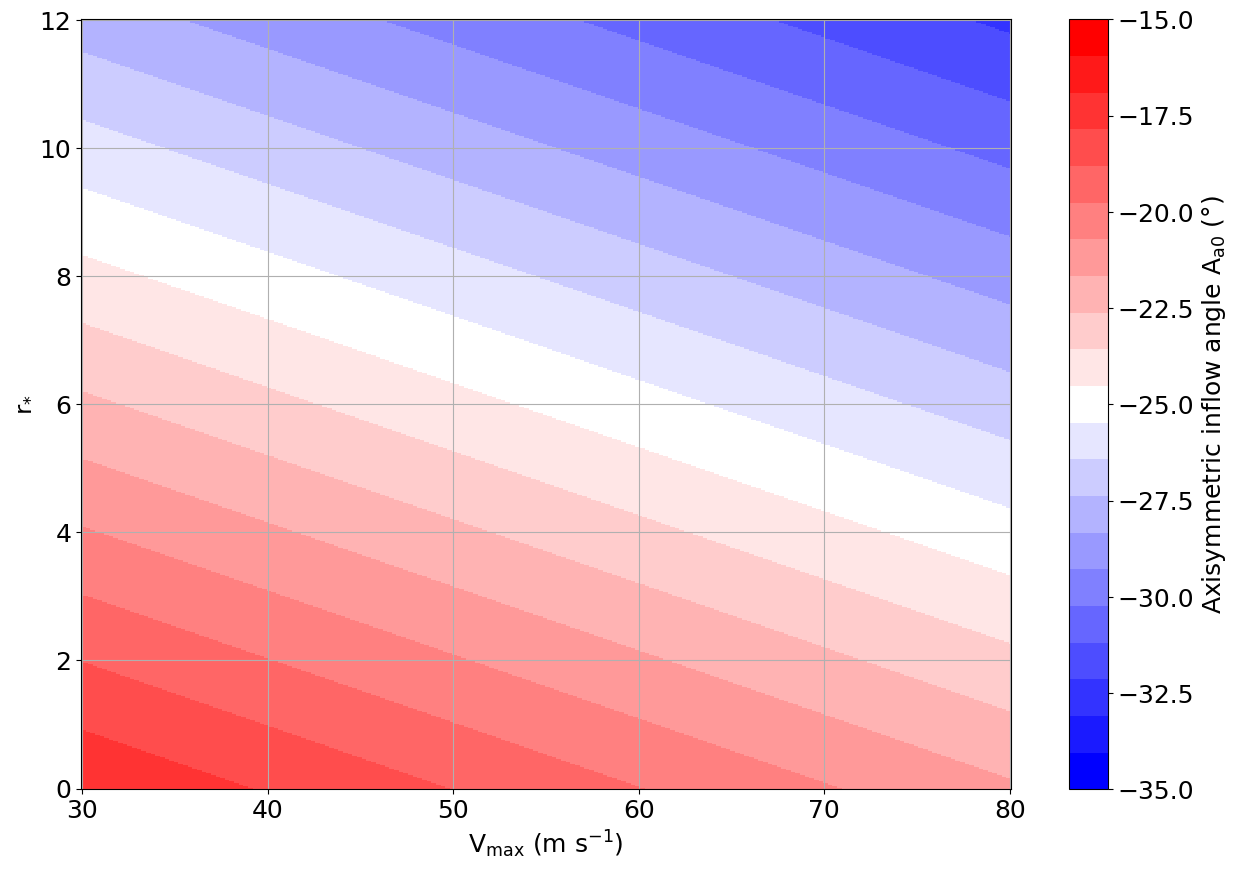

In [14]:
# Fig. 12
v12s       = np.linspace(30, 80, 401)
r12s       = np.linspace(0, 12, 481)
V12s, R12s = np.meshgrid(v12s, r12s)

plt.pcolormesh(V12s, R12s, Aa0(R12s, V12s), cmap=plt.get_cmap('bwr', 21), vmin=-35, vmax=-15)
plt.colorbar(label=r'Axisymmetric inflow angle A$_{\text{a0}}$ (°)')
plt.grid()
plt.xlabel(r'V$_{\text{max}}$ (m s$^{-1}$)')
plt.ylabel(r'r$_{*}$')

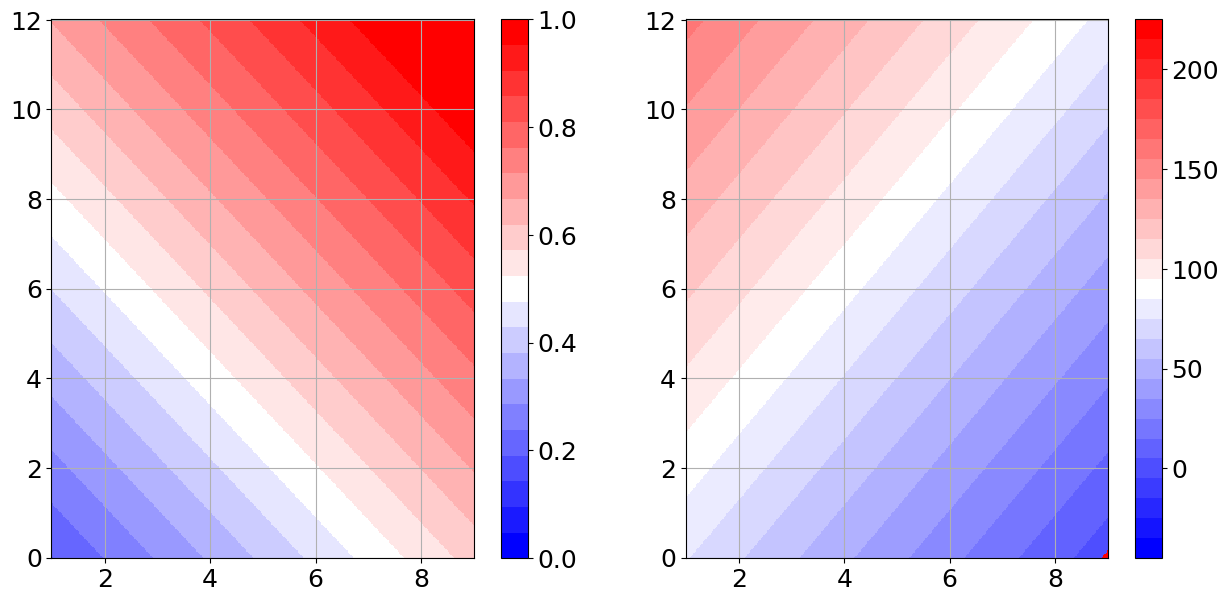

In [5]:
# Fig. 13
v13s       = np.linspace(1, 9, 321)
r13s       = np.linspace(0, 12, 481)
V13s, R13s = np.meshgrid(v13s, r13s)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

im = axes[0].pcolormesh(V13s, R13s, -Aa1_Aa0(R13s, V13s), cmap=plt.get_cmap('bwr', 21), vmin=0, vmax=1)
axes[0].grid()
fig.colorbar(im, ax=axes[0])

im = axes[1].pcolormesh(V13s, R13s, Pa1(R13s, V13s) % 360, cmap=plt.get_cmap('bwr', 27), vmin=-45, vmax=225)
axes[1].grid()
fig.colorbar(im, ax=axes[1])

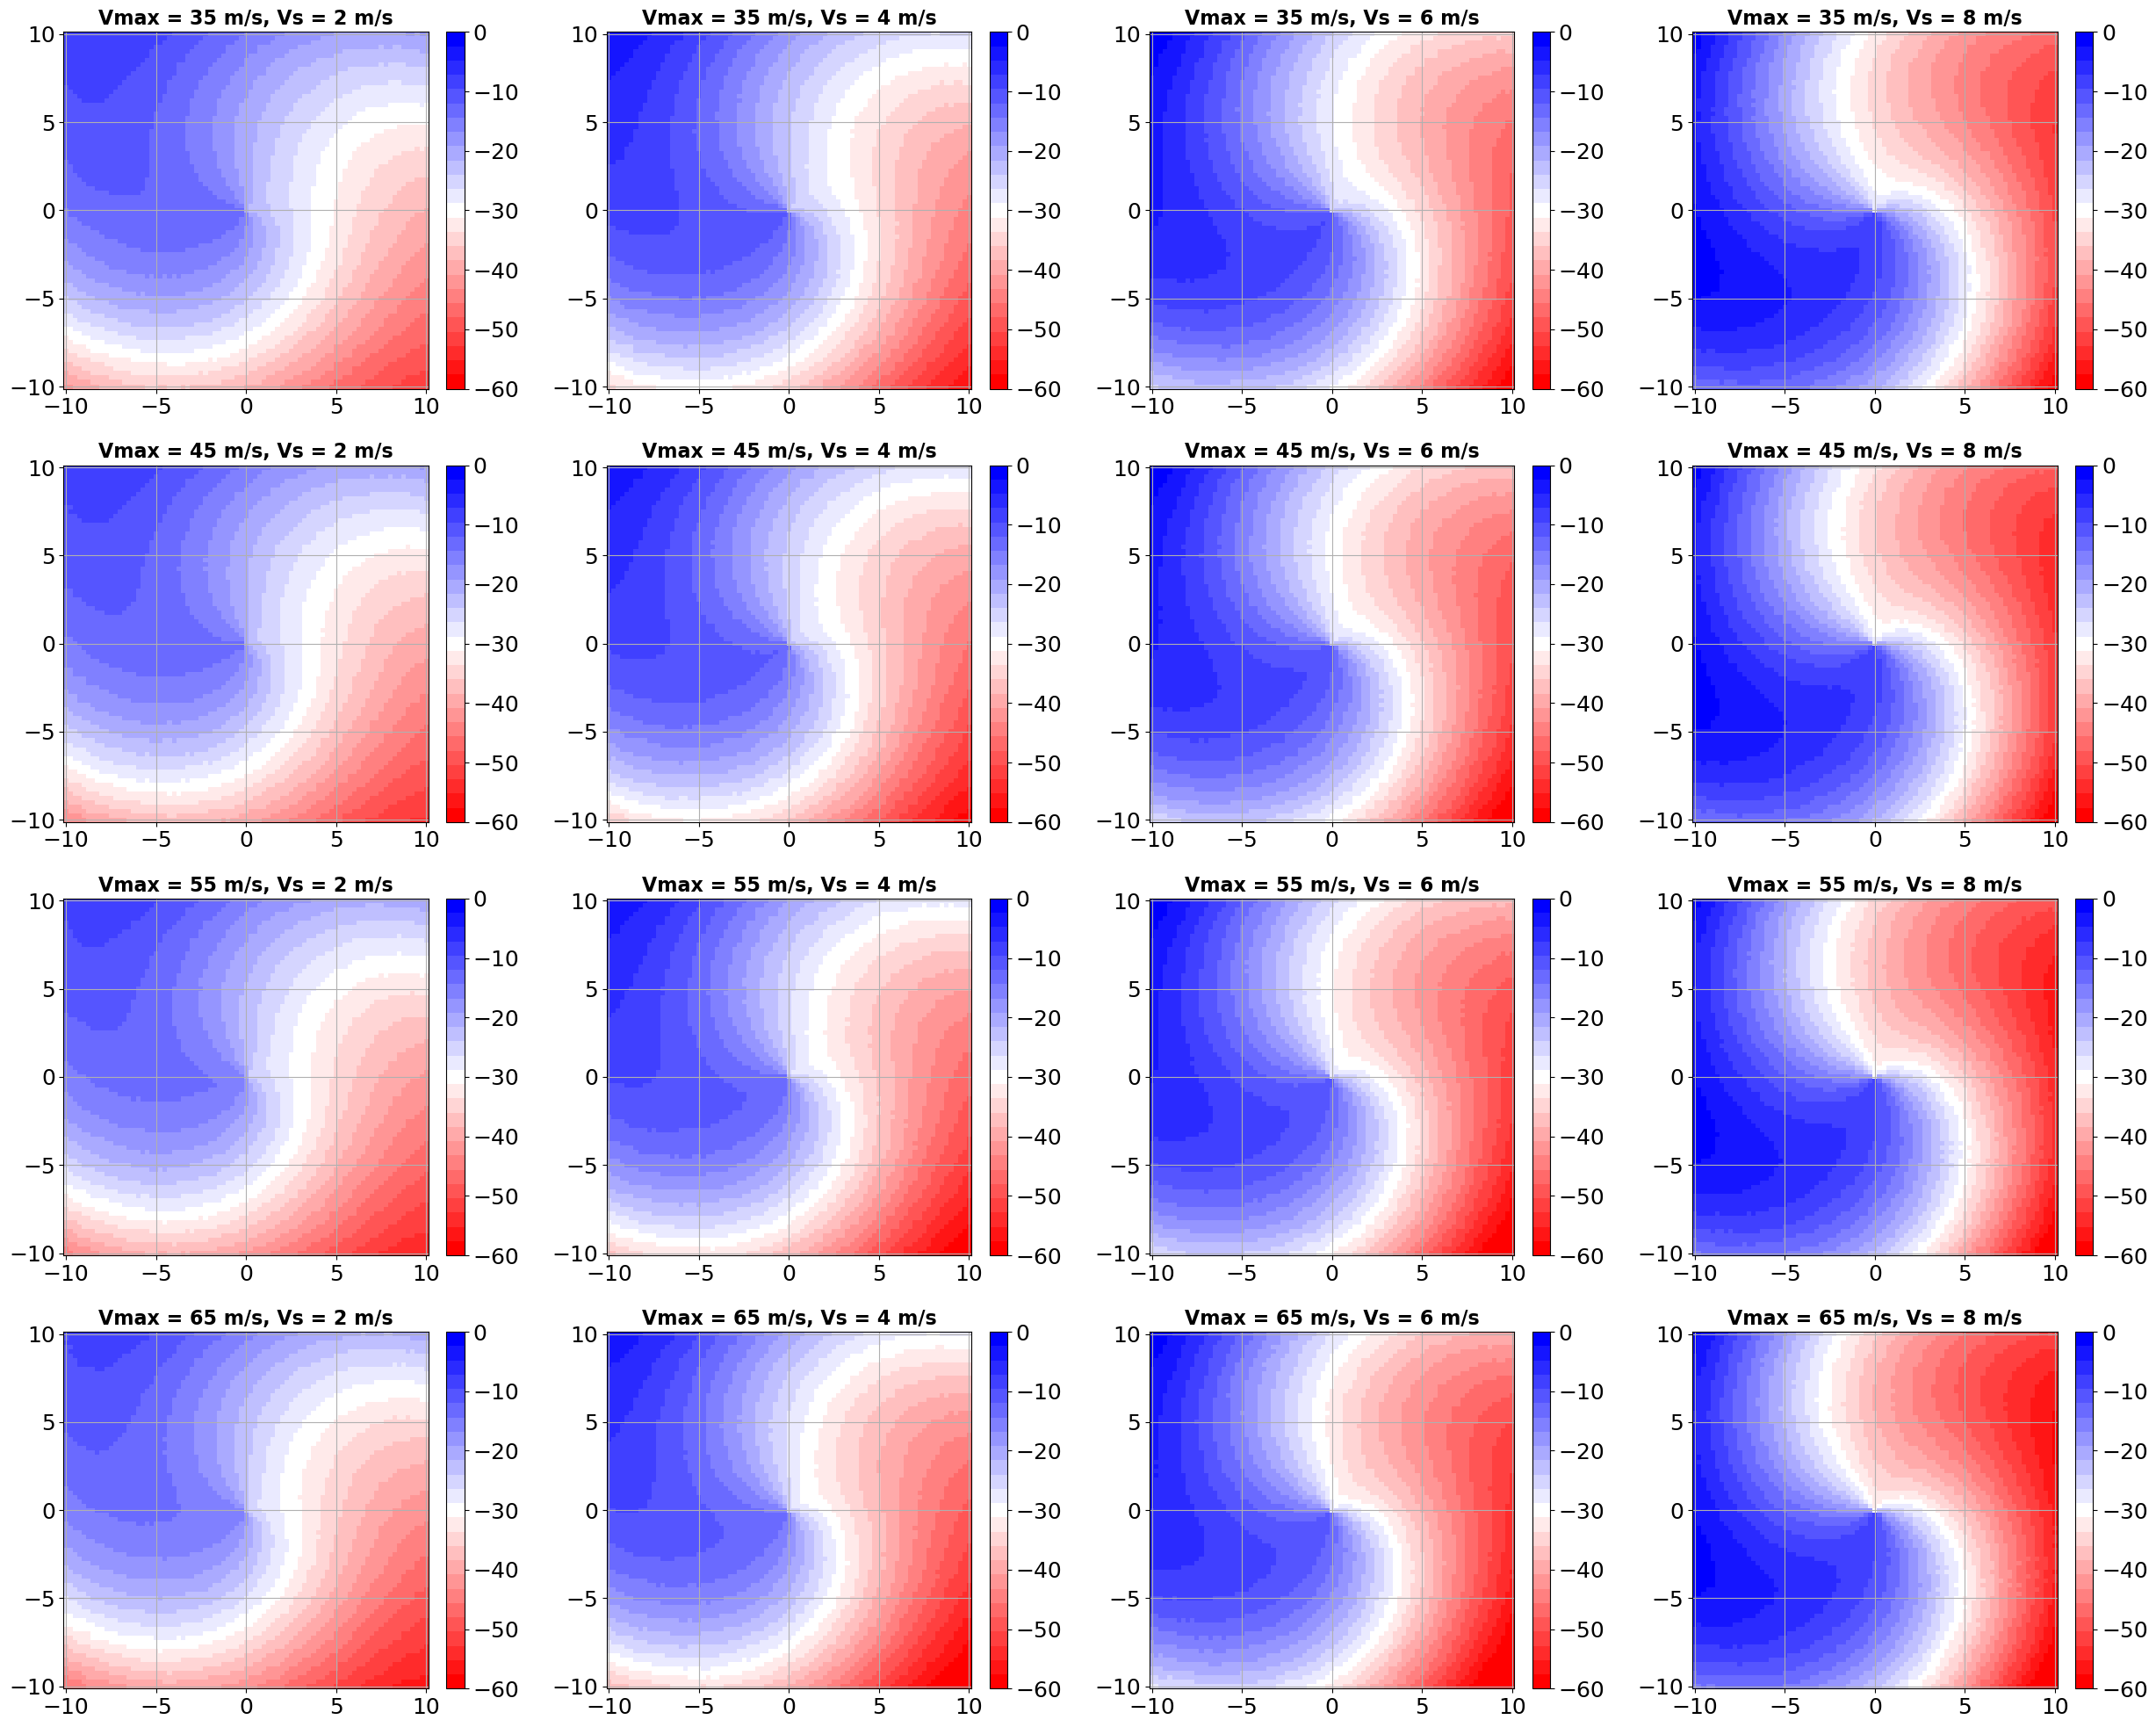

In [6]:
### Plot

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(25, 20))

for i, ax in enumerate(axes.flat):
    a     = inflow_angle(Rs, THs, lvmx[i // 4], lvs[i % 4])
    a_car = get_cartesian_var_from(Rs, -np.pi/2 - THs, a) # Angle definition

    ax.set_title('Vmax = {} m/s, Vs = {} m/s'.format(lvmx[i // 4], lvs[i % 4]), fontsize=16, weight='bold')

    im    = ax.pcolormesh(x_ref, y_ref, a_car, cmap=plt.get_cmap('bwr_r', 25), vmin=-60, vmax=0)
    fig.colorbar(im, ax=ax, pad=0.04)
    
    ax.grid()

plt.tight_layout()

### Test with HY-2

In [35]:
import random

N = 500

sct_pth          = '/home/arthur/data/tropical_cyclones/scatterometer/hy-2/polar/*/*/*/*.nc'
list_of_sct_pths = glob.glob(sct_pth)
print(len(list_of_sct_pths))
sct_sample       = random.sample(list_of_sct_pths, N)
dss              = xr.open_mfdataset(sct_sample, combine='nested', concat_dim='idx')

11809


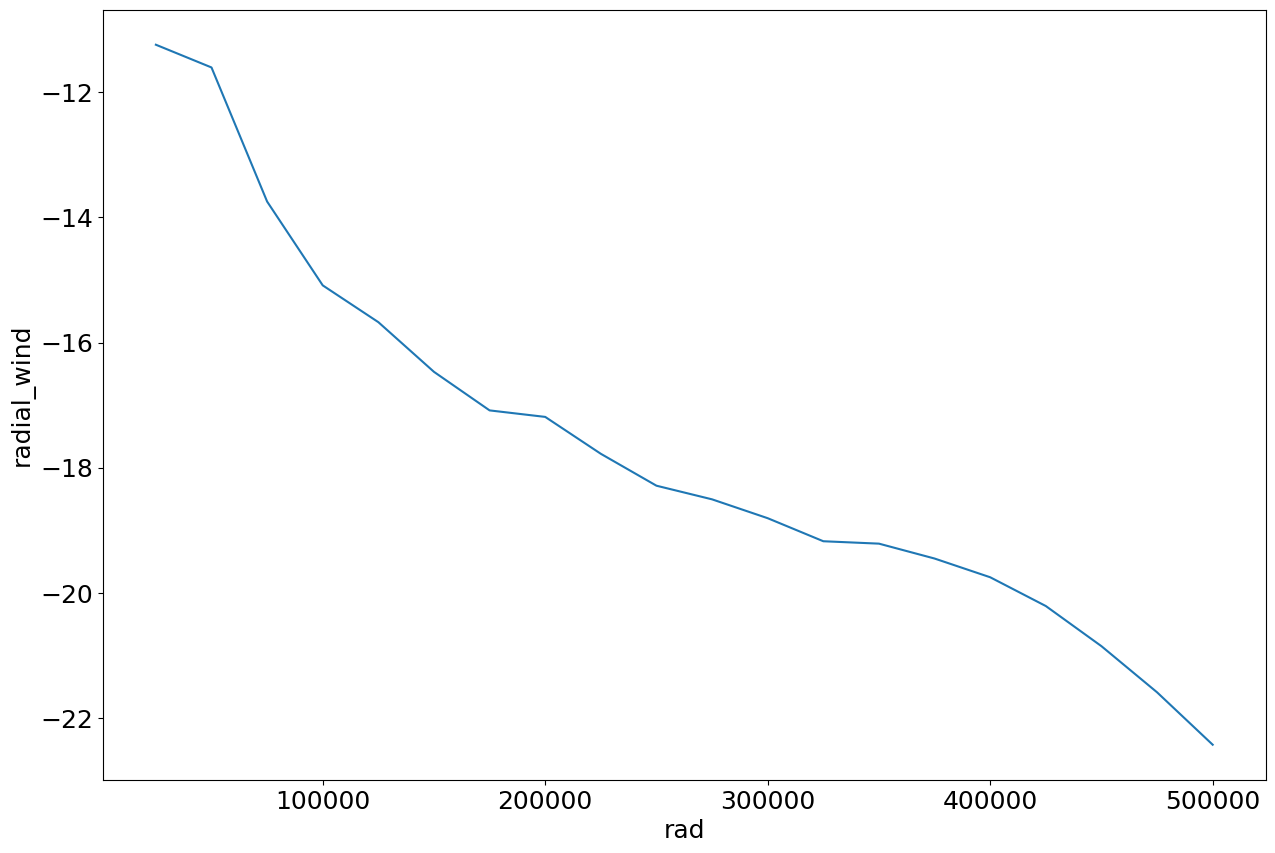

In [36]:
np.rad2deg(np.arctan2(dss.where(dss.lat_ibt > 0).radial_wind, dss.where(dss.lat_ibt > 0).tangential_wind)).mean(dim=['idx', 'theta'], skipna=True).plot()

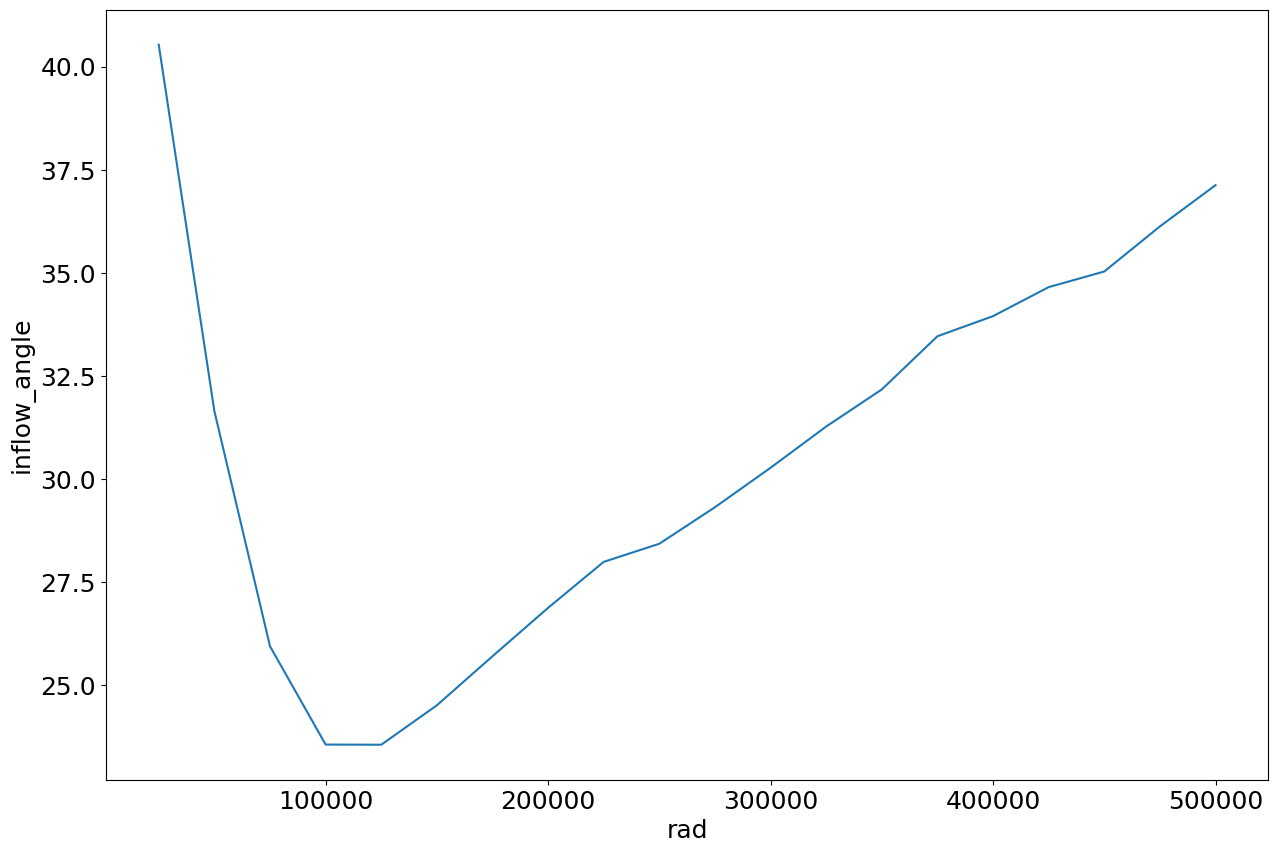

In [30]:
abs(dss.where(dss.lat_ibt > 0).inflow_angle).mean(dim=['idx', 'theta'], skipna=True).plot()